# Финальный проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 

-------------------------------

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm
from scipy.stats import norm 
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

Загрузим датасеты:

In [2]:
# Ссылка для получения информации из области ресурсов диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# ссылки на данные + разделители для csv
links_dic = {
    'groups':       ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
    'groups_add':   ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','],
    'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
    'checks':       ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
            }


# отправляем запрос на получение ссылки для скачивания и скачиваем файлы
for csv_filename, csv_link in links_dic.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

-------------------------------
Сократим названия id:

In [3]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

Обзор данных:

In [4]:
# обзор датафреймов
# в каждом датасете проверяем уникальность всех id
for x in ['groups', 'groups_add', 'active_studs', 'checks']:
    print(x)
    y = globals()[x]
    print(y.head(), '\n')
    print('Кол-во ID:', y.id.count(), '\n')
    print('Кол-во уникальных ID:', y.id.nunique())
    print('______________________________\n\n\n')

groups
     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

Кол-во ID: 74484 

Кол-во уникальных ID: 74484
______________________________



groups_add
        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

Кол-во ID: 92 

Кол-во уникальных ID: 92
______________________________



active_studs
        id
0   581585
1  5723133
2  3276743
3  4238589
4  4475369 

Кол-во ID: 8341 

Кол-во уникальных ID: 8341
______________________________



checks
       id    rev
0    1627  990.0
1    3185  690.0
2   25973  690.0
3   26280  690.0
4  100300  990.0 

Кол-во ID: 541 

Кол-во уникальных ID: 541
______________________________





In [5]:
for x in ['groups', 'groups_add', 'active_studs', 'checks']:
    y = globals()[x]
    print('Кол-во пропусков:', '\n', y.isna().sum(), '\n')
    print('Кол-во дупликатов:', y.duplicated().sum())
    print('______________________________\n\n\n')

Кол-во пропусков: 
 id     0
grp    0
dtype: int64 

Кол-во дупликатов: 0
______________________________



Кол-во пропусков: 
 id     0
grp    0
dtype: int64 

Кол-во дупликатов: 0
______________________________



Кол-во пропусков: 
 id    0
dtype: int64 

Кол-во дупликатов: 0
______________________________



Кол-во пропусков: 
 id     0
rev    0
dtype: int64 

Кол-во дупликатов: 0
______________________________





----------------
Требуется проверить все имеющиеся пересечения множеств id из разных таблиц.
Проверим, присутствуют ли id из `groups_add` в `active_studs` и `checks`:

In [6]:
print('Кол-во id из groups_add в active_studs:', groups_add.query('id in @active_studs.id').shape[0], 
      '\nКол-во id из groups_add в checks:',     groups_add.query('id in @checks.id').shape[0])

Кол-во id из groups_add в active_studs: 13 
Кол-во id из groups_add в checks: 1


-------------------------------
Проверим на пересечение id из `groups` и `groups_add`:

In [7]:
print('Кол-во общих id в groups и groups_add:', 
      len(set(groups_add.id) & set(groups.id)))

Кол-во общих id в groups и groups_add: 0


-------------------------------
Соединим датафрейм `groups` c датафреймом `groups_add`:

In [8]:
groups_full = pd.concat([groups, groups_add])

In [9]:
print('Доля активных пользователей, отсутствующих/присутствующих в общем списке:\n', 
      len(set(active_studs.id) - set(groups_full.id)),'/', 
      len(set(active_studs.id) & set(groups_full.id)),
      '\nДоля оплативших пользователей, отсутствующих/присутствующих в общем списке:\n',
      len(set(checks.id) - set(groups_full.id)),'/', 
      len(set(checks.id) & set(groups_full.id)),
      '\nДоля оплативших пользователей, отсутствующих/присутствующих в списке активных:\n',
      len(set(checks.id) - set(active_studs.id)),'/', 
      len(set(checks.id) & set(active_studs.id)))

Доля активных пользователей, отсутствующих/присутствующих в общем списке:
 0 / 8341 
Доля оплативших пользователей, отсутствующих/присутствующих в общем списке:
 0 / 541 
Доля оплативших пользователей, отсутствующих/присутствующих в списке активных:
 149 / 392


-------------------------------
Диаграмма Эйлера, демонстирующая имеющиеся взаимосвязи id разных табилц:

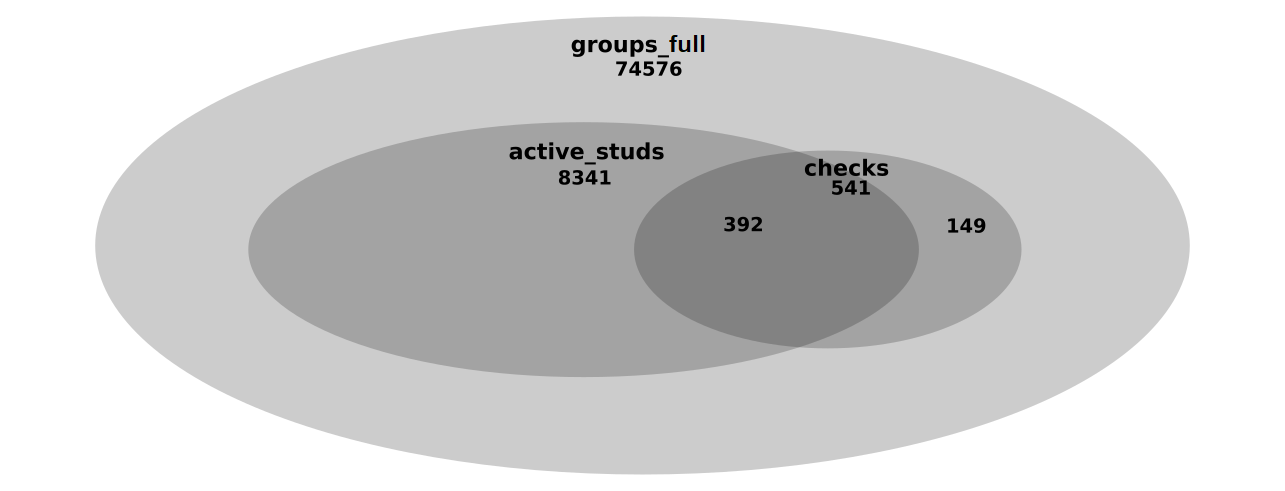

-------------
В период проведения экспериментов были оплаты и от не посещавших платформу студентов. Возможно, это оплаты другими способами, например, автоматические оплаты по подписке.

Возможно это автоматические платежи, а возможно ошибка в данных и все оплатившие являются активными. Так как у нас нет возможности выяснить это, уберём из выборки оплативших не активных.

In [10]:
checks_relev = checks[checks.id.isin(active_studs.id)]

In [11]:
checks_relev.count()

id     392
rev    392
dtype: int64

-------------------------------
Создадим таблицы с распределением активных и оплативших по группам А/B:

In [12]:
df_visit = active_studs.merge(groups_full, on='id')
df_bought = checks_relev.merge(groups_full, on='id')

Проверим в них распределение по группам:

<Axes: title={'center': 'users_bought'}, xlabel='grp', ylabel='count'>

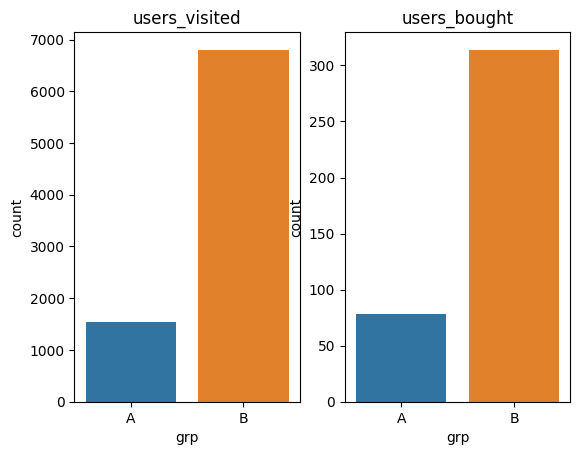

In [13]:
fig, axes = plt.subplots(1, 2)#, sharex=True, figsize=(10,5))
axes[0].set_title('users_visited')
axes[1].set_title('users_bought')
sns.countplot(ax=axes[0], x='grp', 
              data=df_visit)
sns.countplot(ax=axes[1], x='grp', 
              data=df_bought)

Проверим наличие выбросов:

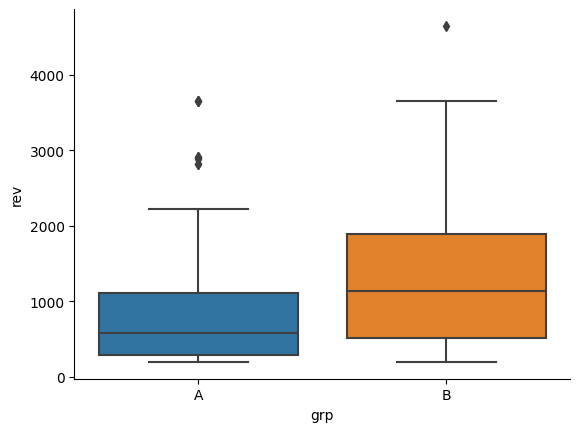

In [14]:
sns.boxplot(data=df_bought, y='rev', x='grp')
sns.despine()

Имеются незначительные выбросы.

-------------------------------
Пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.

-------------------------------
### Выбор метрики

У нас имеются 4 переменные - 
1) id активных - df_bought.id 
2) id оплативших- df_visit.id, 
3) размер оплат - df_bought.rev
4) id всех юзеров 

<br>Как может влиять новая механика оплаты на них?
- Может увеличиться доля оплативших среди активных
- Платящие пользователи могут начать тратить больше, если оплата стала проще
- Механика не влияет на долю активных среди всех!!

<br>Данные изменения отражают 3 метрики:
- CR - конверсия из активных в оплатившие 
- ARPPU - средний доход с оплатившего юзера 
- ARPU - средний доход с активного юзера
<br>(является производной остальных двух: ARPU = CR * ARPPU)

На данные метрики также могут влиять такие факторы, как качество трафика/мотивированность пользователей, фичи конкурентов, рекламные компании и др. Дизайн эксперимента должен был исключить влияние других факторов насколько возможно.

In [15]:
CR = []
ARPPU = []
ARPU=[]

for gr in df_bought.grp.unique():
    CR.append( round( df_bought.query('grp==@gr').id.count()
              /df_visit.query('grp==@gr').id.count(), 4) )
    
    ARPPU.append( round( df_bought.query('grp==@gr').rev.mean(), 2))
    
    ARPU.append( round( df_bought.query('grp==@gr').rev.sum()/df_visit.query('grp==@gr').id.count(), 2))

percent = []
for x in [CR, ARPPU, ARPU]:
    percent.append( round( abs( 100*(x[1]-x[0])/x[0]), 2))
    
print('\n\033[1mCR\033[0m\nКонверсия оплативших пользователей:\nГруппа А:',
      CR[0], '\nГруппа В:', CR[1],
      '\nКонверсия у группы В на', percent[0],
      '% меньше, чем у группы А')

print('\n\033[1mARPPU\033[0m\nОтношение общей суммы на количество активных оплативших пользователей:\nГруппа А:',
      ARPPU[0], '\nГруппа В:', ARPPU[1],
      '\nARPPU группы В на', percent[1],
      '% больше, чем у группы А')

print('\n\033[1mARPU\033[0m\nОтношение общей суммы на количество активных пользователей:\nГруппа А:',
      ARPU[0], '\nГруппа В:', ARPU[1],  
      '\nARPU группы В на', percent[2],
      '% больше, чем у группы А')


CR
Конверсия оплативших пользователей:
Группа А: 0.0507 
Группа В: 0.0462 
Конверсия у группы В на 8.88 % меньше, чем у группы А

ARPPU
Отношение общей суммы на количество активных оплативших пользователей:
Группа А: 933.59 
Группа В: 1257.88 
ARPPU группы В на 34.74 % больше, чем у группы А

ARPU
Отношение общей суммы на количество активных пользователей:
Группа А: 47.35 
Группа В: 58.06 
ARPU группы В на 22.62 % больше, чем у группы А


-------------------------------
### Имеются ли различия в показателях и с чем они могут быть связаны?
Видим, что конверсия `CR` падает, но доход на пользователя/покупателя `ARPU`/`ARPPU` растёт. 

Возможно падение конверсии случайно, в то время как рост `ARPPU` нет, нужны результаты о статистической значимости. Кроме того, ответ в такой ситуации может крыться в сегментах/срезах. Посмотрим на распределение чеков в поисках ответов.

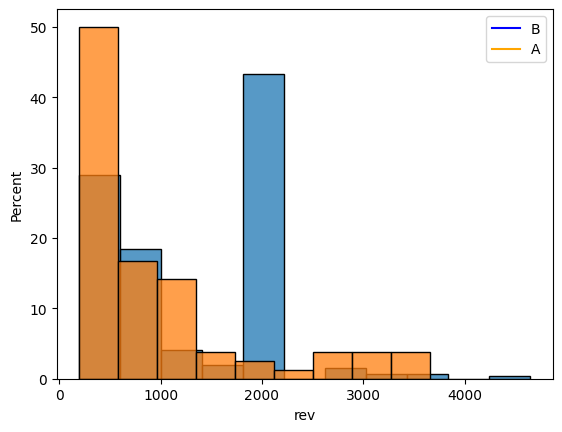

In [16]:
from matplotlib.lines import Line2D

f, ax = plt.subplots(1, 1)
a = Line2D([], [], color='blue', label='B')
b = Line2D([], [], color='orange', label='A')

sns.histplot(ax=ax, data=df_bought.query('grp=="B"').rev, stat='percent')
sns.histplot(ax=ax, data=df_bought.query('grp=="A"').rev, stat='percent')

plt.legend(handles=[a, b])
#ax.legend(labels=["B", "A"])

In [17]:
pd.concat([df_bought.query('grp=="B"').rev.describe().to_frame().rename(columns={'rev': 'Группа В'}), 
           df_bought.query('grp=="A"').rev.describe().to_frame().rename(columns={'rev': 'Группа A'})], axis=1)

,Группа В,Группа A
count,314.000000,78.000000
mean,1257.878992,933.589744
std,790.864254,919.932711
min,199.000000,199.000000
25%,511.750000,290.000000
50%,1140.000000,585.000000
75%,1900.000000,1114.750000
max,4650.000000,3660.000000


Возможно при уменьшении конверсии произошло отсечение части пользователей платящих малые суммы.

Стоит отметить, что данные распределены не нормально. 

-------------------------------
### Являются ли эти различия статистически значимыми?
При сравнении конверсии у нас имеется две номинативные переменные: 1.)оплатил/не_оплатил 2.)grp, поэтому стоит использовать `Хи-квадрат`.
<br>ARPU и ARPPU - зависимость количественной переменной(rev) от номинативной(grp).
Размеры групп очень сильно отличаются, поэтому Т-тест может давать большие погрешности.
Можно использовать Welch T-test, Mann-Whitney или Bootstrap.
Кроме того, из гистограм видно, что распределение наших данных значительно отличается от нормального. Также известно о наличии выбросов.
В таком случае идеально подходит Mann-Whitney и bootstrap. Результаты Mann-Whitney сложнее интерпретировать, поэтому используем `bootstrap`.

* Строим `bootstrap` распределения для групп А и B.
* Вычислим их разницу.
* В получившемся рапределении разницы находим доверительный интервал.
* Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.

-------------------------------
### CR

Сформулируем нулевую и альтернативную гипотезы:

* `H0`: CR в двух группах одинаковые.
* `H1`: CR в двух группах различаются.

In [18]:
group_A = [df_visit.query('grp=="A"').count()[0], df_bought.query('grp=="A"').count()[0]]
group_B = [df_visit.query('grp=="B"').count()[0], df_bought.query('grp=="B"').count()[0]]

# Запустим тест
chi2, p, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
print("Хи-квадрат p-value: ", p)

Хи-квадрат p-value:  0.4672642540463894


**Нельзя утверждать, что различия CR в двух группах есть.**

-----
Функция для проверки гипотез с помощью bootstrap:

In [19]:
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it   = 1000,                    # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph         = True,                # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len  = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant  = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x     = 0, 
        loc   = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x     = 0, 
        loc   = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отрисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

Данная функция требует на вход два столбца данных(А и B) и функцию подсчета метрики.

<br>Для ARPPU и ARPU подойдет ф-я np.mean(x):

In [20]:
def mean_f(y):
    return np.mean(y)

Эти функции требуют создания новых датафреймов и столбцов.
_________________
Объединим таблицы клиентов и юзеров: 

In [21]:
df_visit_bought = df_visit.merge(df_bought, on=['id', 'grp'], how='left')

Заполним пропущенные значения оплат нулями:

In [22]:
df_visit_bought.rev = df_visit_bought.rev.fillna(0)

разделим на группы A и B:

In [23]:
grp_a = df_visit_bought.query('grp=="A"')
grp_b = df_visit_bought.query('grp=="B"')

-------------------------------
### ARPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPU в двух группах одинаковые.
* `H1`: ARPU в двух группах различаются.

In [24]:
get_bootstrap(grp_a.rev, grp_b.rev, statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                0
 0.025   0.362366
 0.975  21.172215,
 'p_value': 0.04454591484050235}

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPU в двух группах различаются.

-------------------------------
### ARPPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPPU в двух группах одинаковые.
* `H1`: ARPPU в двух группах различаются.

In [25]:
get_bootstrap(grp_a.rev[grp_a.rev > 0], grp_b.rev[grp_b.rev > 0], statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                 0
 0.025  195.703594
 0.975  463.276444,
 'p_value': 1.1842881943704748e-06}

**У нас имеется неопределенность по поводу юзеров которые оплатили**, но не присутствовали на сайте.
<br>У меня нету возможности распросить коллег/заказщика о причине этой аномалии. Поэтому мне стоит на всякий случай провести все тесты, на этот раз включая эти данные

In [26]:
df_visit = active_studs.merge(groups_full, on='id')
df_bought = checks.merge(groups_full, on='id') #использую checks а не checks_relev

In [27]:
df_visit_bought = df_visit.merge(df_bought, on=['id', 'grp'], how='left')

Заполним пропущенные значения оплат нулями:

In [28]:
df_visit_bought.rev = df_visit_bought.rev.fillna(0)

разделим на группы A и B:

In [29]:
grp_a = df_visit_bought.query('grp=="A"')
grp_b = df_visit_bought.query('grp=="B"')

In [30]:
group_A = [df_visit.query('grp=="A"').count()[0], df_bought.query('grp=="A"').count()[0]]
group_B = [df_visit.query('grp=="B"').count()[0], df_bought.query('grp=="B"').count()[0]]

# Запустим тест
chi2, p, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
print("Хи-квадрат p-value: ", p)

Хи-квадрат p-value:  0.43714838107439424


In [31]:
get_bootstrap(grp_a.rev, grp_b.rev, statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                0
 0.025   0.572343
 0.975  20.427308,
 'p_value': 0.037047285172488544}

In [32]:
get_bootstrap(grp_a.rev[grp_a.rev > 0], grp_b.rev[grp_b.rev > 0], statistic = mean_f, 
              graph = False, show_progress = False)

{'ci':                 0
 0.025  189.473260
 0.975  460.508213,
 'p_value': 1.4689904356023145e-06}

Тесты показали те же результаты.

-------------------------------
### Стоит ли запускать новую механику на всех пользователей?
**Да**, новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU, отрицательное изменение метрики CR не подтвердилось.